<a href="https://colab.research.google.com/github/minerva79/GMS5204/blob/main/Lab2_1_Clustering_CKD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GMS 5204 - Unsupervised Learning

Unsupervised learning techniques are used to find hidden patterns in data, such as distinct groups of patients with different characteristics without relying on labels. Methods such as Principal Component Analysis (PCA) and K-Means clustering are some examples of this.

In this example, we will use PCA for dimensionality reduction and to determine new key features that are derived from the existing continuous features such as age, creatinine etc. We will also use K-Means to perform clustering on the dataset look at the resulting cluster characteristics.


The datasets in this notebook can be obtained from the **UCI Machine Learning Repository**

1. Chronic Kidney Disease Dataset: https://archive.ics.uci.edu/ml/datasets/chronic_kidney_disease

**References**:

1. Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


In [1]:
!pip install pydantic-settings
!pip install ydata-profiling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.0/679.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.9 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=36d6b04a749e22ac7dd094a017d5105cd7939ef64cf81436b6fe95787eafba68
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin
  Attempting uninstall: scipy
    Fo

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import  StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from ydata_profiling import ProfileReport


pd.set_option('display.max_columns', None)

**Continuous and Categorical Variables**

For most clustering methods, categorical variables are an issue as they cannot be directly used with these methods. Clustering methods often use a distance-based measure to measure the distance, or difference between two cases or a cluster center, which might be applicable for continuous variables such as sodium levels. However for categorical variables, they can only take on a discrete or fixed value such as 0 or 1, or a list of conditions and may not have an inherent ranking among them. Hence, simply calculating the distance between an integer representation such as 1,2,3,4... does not represent the contribution from this variable appropriately.

As such, we only utilize the numeric columns from the ckd dataset that was cleaned in the previous lecture. These numeric columns are only associated with CKD positive cases.
- **age** - age
- **bp** - blood pressure
- **sg** - specific gravity
- **al** - albumin
- **su** - sugar
- **bgr** - blood glucose random
- **bu** - blood urea
- **sc** - serum creatinine
- **sod** - sodium
- **pot** - potassium
- **hemo** - hemoglobin
- **pcv** - packed cell volume
- **wbcc** - white blood cell count
- **rbcc** - red blood cell count

**OBJECTIVE:** To evaluate the clusters of CKD patients with similar characteristics based on these numeric columns. Clustering analysis is typically an exploratory analysis for hypothesis generation.


In [3]:
url = 'https://raw.githubusercontent.com/seanlam74/GMS5204/main/ckd_numeric_data.csv'
ckd=pd.read_csv(url)
ckd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     250 non-null    float64
 1   bp      250 non-null    float64
 2   sg      250 non-null    float64
 3   al      250 non-null    float64
 4   su      250 non-null    float64
 5   bgr     250 non-null    float64
 6   bu      250 non-null    float64
 7   sc      250 non-null    float64
 8   sod     250 non-null    float64
 9   pot     250 non-null    float64
 10  hemo    250 non-null    float64
 11  pcv     250 non-null    float64
 12  wbcc    250 non-null    float64
 13  rbcc    250 non-null    float64
dtypes: float64(14)
memory usage: 27.5 KB


## 1 Data Scaling & Categorical Variables for Clustering

**Data Scaling**

In the CKD dataset, certain variables such as **wbcc** have a much higher value than the other variables. Although this is a continuous variable, the large values may have a much higher influence on the total variance of the dataset. This in turn affects the use of PCA, which determines the contribution of the component to the total variance as well as K-Means, which relies on the distance between data points. Hence, the dataset needs to be normalized, or scaled to a standard range before performing PCA or K-Means clustering.

In [4]:
ckd.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,54.443468,79.498763,1.014505,1.606780,0.711225,171.257550,71.610937,4.350478,135.091430,4.795045,10.993264,34.533046,8806.824312,4.323288
std,17.115776,14.937872,0.004417,1.281575,1.229581,85.335639,57.134411,6.786825,10.299631,3.530522,2.104097,6.704154,2797.974888,0.722276
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.500000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,48.000000,70.000000,1.010000,1.000000,0.000000,111.250000,32.000000,1.500000,134.000000,4.100000,9.800000,30.000000,7900.000000,3.900000
50%,59.000000,80.000000,1.015000,1.016949,0.000000,148.036510,55.000000,2.450000,137.528750,4.627243,11.300000,36.000000,8406.122000,4.707435
75%,65.000000,90.000000,1.017408,3.000000,0.450142,210.000000,89.750000,4.250000,137.528750,4.627243,12.526437,38.884500,9575.000000,4.707435
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,16.100000,52.000000,26400.000000,8.000000


In [5]:
file = ProfileReport(ckd)
file.to_file(output_file='output_ckd.html')
#if using google colab, change to correct path
#profile.to_file('/content/drive/My Drive/output_ckd.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 14/14 [00:00<00:00, 130.30it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# Rescaling of numeric columns with Standardization
ckd_std = StandardScaler().fit_transform(ckd)

# Convert the standardized data back into a DataFrame
numeric_cols = ['age','bp','sg','al','su','bgr','bu','sc','sod','pot','hemo','pcv','wbcc','rbcc']
ckd_std_df = pd.DataFrame(ckd_std, columns=numeric_cols)


In [7]:
ckd_std_df

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
0,-0.377219,0.033622,1.246765,-0.474414,-0.579589,-0.590121,-0.624534,-0.465136,0.237116,-0.047624,2.098561,1.414935,-0.360562,1.216254
1,-2.777475,-1.978725,1.246765,1.871151,-0.579589,-0.272660,-0.940212,-0.524192,0.237116,-0.047624,0.146073,0.518173,-1.005175,0.532924
2,0.442381,0.033622,-1.021948,0.307441,1.865161,2.955945,-0.326393,-0.376552,0.237116,-0.047624,-0.663496,-0.528051,-0.467998,0.532924
3,-0.377219,-0.637160,-2.156305,1.871151,-0.579589,-0.637089,-0.273780,-0.081272,-2.343750,-0.651362,0.098451,-0.378590,-0.754492,-0.587223
4,-0.201590,0.033622,-1.021948,0.307441,-0.579589,-0.766250,-0.799911,-0.435608,0.237116,-0.047624,0.288938,0.069791,-0.539621,0.383880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,-0.377219,1.375187,0.658692,-0.461162,-0.212761,-0.801476,0.129587,0.140187,-0.008895,0.427125,-2.235010,-2.321576,-0.575433,-2.390701
246,-0.377219,2.045969,0.112409,1.089296,-0.579589,-0.766250,2.514714,1.601822,-1.468179,0.256838,-1.139712,-1.275353,-1.363293,-2.529430
247,-0.025962,0.704404,2.381122,-0.474414,-0.579589,-0.249605,-0.940212,-0.465136,0.477533,-0.168881,0.730122,0.650370,-0.143499,0.532924
248,0.266752,-0.637160,-1.021948,-0.474414,1.865161,2.967687,-0.291318,-0.391316,0.282962,-0.083737,0.765154,0.368712,0.498922,-0.309765


## 2 K-Means Clustering

K-Means clustering is an iterative algorithm that aims to find *k* number of cluster centers, given the variables in the input dataset. As this is an unsupervised learning method, no labels are required and the goal is to find patterns or natural clusters in the dataset. The algorithm starts by randomly initializing a given number of cluster centers, and iteratively updates these center positions according to the intra-cluster and inter-cluster distances between the cases and other cluster centers respectively. The ``KMeans()`` object from ``sklearn.cluster`` can be used to perform K-Means clustering on the CKD dataset.

### Number of Clusters

In K-Means clustering, a key parameter is the number of initial clusters to use and can be determined using the inertia or within-cluster sum-of-squares. By plotting the inertia over different number of clusters, the optimal number of clusters can be determined by looking at the changes in inertia between each number of clusters. This is known as the **elbow method**, where a point is preceded by a large drop in inertia and followed by gradual decrease in inertia.

Run the code below to plot the inertia values over varying numbers of clusters and observe the points. What would be a suitable number of clusters to use?

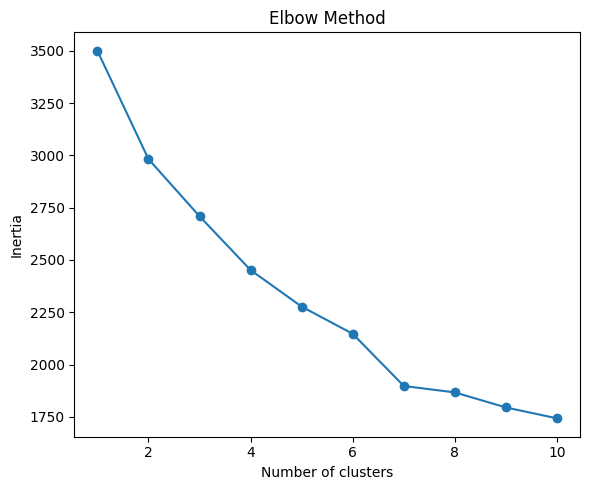

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertias = []
range_of_clusters = range(2, 11)  # start from 2 for silhouette scores

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='random', random_state=0,n_init='auto')
    kmeans.fit(ckd_std_df)
    inertias.append(kmeans.inertia_)

# Plotting inertia
plt.figure(figsize=(6, 5))
plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.tight_layout()
plt.show()

In [9]:
# We decide to have 3 clusters (there are also other metrics that can be used to decide the number of clusters)
# Fit KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, init='random', random_state=0)
kmeans.fit(ckd_std)
ckd['cluster'] = kmeans.labels_ # Add the cluster labels to a new column in ckd


In [10]:
ckd['cluster'].unique()

array([0, 2, 1], dtype=int32)

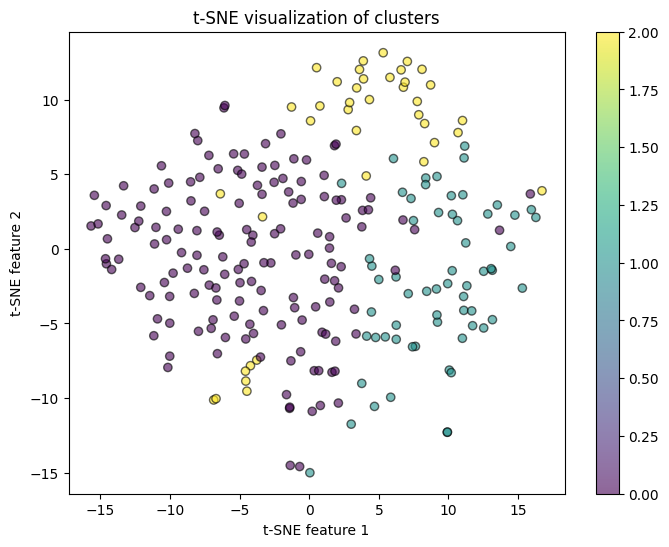

In [11]:
from sklearn.manifold import TSNE

# Applying t-SNE to reduce dimensionality for ckd_std data
tsne = TSNE(n_components=2, random_state=42)  # Using two components for a 2D plot
ckd_tsne = tsne.fit_transform(ckd_std)

# Assign labels to your data
cluster_labels = kmeans.labels_

# Plotting the t-SNE output with cluster labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(ckd_tsne[:, 0], ckd_tsne[:, 1], c=cluster_labels, cmap='viridis', marker='o', edgecolor='k', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE visualization of clusters')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

### Basic Interpretation of Clusters
Clustering allows us to discover similarities within cluster and differences across clusters. We can use the centroids of the clusters to interpret them. Since they are normal standardized scores, we know that a negative number means that the centroid below the mean and the positive number means the centroid is above the mean.

Other more advanced analysis can be done.

In [12]:
# Extract centroids as preliminary interpretation of the clusters.
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns=ckd[numeric_cols].columns)
print(centroid_df)



        age        bp        sg        al        su       bgr        bu  \
0 -0.116166 -0.150167  0.143162 -0.215159 -0.398263 -0.386721 -0.324877   
1  0.135472  0.170450 -0.285338  0.461760 -0.076155 -0.143500  0.973780   
2  0.228449  0.302742 -0.093337  0.087937  1.642635  1.705601 -0.306865   

         sc       sod       pot      hemo       pcv      wbcc      rbcc  
0 -0.216232  0.177046 -0.099949  0.382598  0.427541 -0.090465  0.380353  
1  0.670143 -0.452731  0.305651 -1.184058 -1.206279  0.039462 -1.106579  
2 -0.239238  0.043318 -0.104051  0.420630  0.284250  0.282889  0.306033  


Given the centroid values for the clusters, we can provide a detailed interpretation of each cluster based on the standardized scores of the features. Standardized scores (z-scores) help in understanding whether a feature's value for the cluster is above or below the overall mean (where a mean of 0 and standard deviation of 1 are assumed for each feature across the dataset).

**Interpretation of Cluster 0**
Cluster 0 likely represents younger individuals with overall good health indicators. The lower values in blood glucose and blood urea, along with good red blood cell metrics, suggest fewer chronic conditions related to the kidneys and cardiovascular health.

**Interpretation of Cluster 1**
Cluster 1 might represent individuals with more severe health issues, given higher values in albumin, blood urea, serum creatinine, and significantly negative scores in hemoglobin and pcv.

**Interpretation of Cluster 2**
Cluster 2 shows a high sugar and blood glucose random profile, potentially indicating individuals with issues related to diabetes or higher risk thereof.

- **age** - age
- **bp** - blood pressure
- **sg** - specific gravity
- **al** - albumin
- **su** - sugar
- **bgr** - blood glucose random
- **bu** - blood urea
- **sc** - serum creatinine
- **sod** - sodium
- **pot** - potassium
- **hemo** - hemoglobin
- **pcv** - packed cell volume
- **wbcc** - white blood cell count
- **rbcc** - red blood cell count

**Interpretation will require domain knowledge and clinical judgement**

### Confirmation with the actual statistics (non-standardized) for the 3 clusters

The actual statistics may be different from the standardized statistics. For example, the mean age for cluster 1 appears to be lower than that of cluster 0.
In interpretation of clustering results, it is important to check the statistics for the original scale.

In [13]:
ckd[ckd['cluster'] == 0].describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,cluster
count,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.0
mean,52.459174,77.260084,1.015136,1.331589,0.222509,138.322542,53.086463,2.885886,136.911292,4.442880,11.796675,37.393607,8554.211517,4.597458,0.0
std,19.716730,12.887553,0.004344,1.175838,0.500634,42.817551,33.786228,4.476242,4.615018,0.592051,1.513456,4.208453,1979.846987,0.497417,0.0
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.500000,104.000000,2.800000,5.800000,25.000000,2200.000000,2.400000,0.0
25%,45.000000,70.000000,1.010000,0.000000,0.000000,105.000000,27.000000,1.300000,136.000000,4.100000,11.000000,35.000000,8406.122000,4.600000,0.0
50%,57.000000,76.469070,1.015000,1.016949,0.000000,140.000000,48.000000,1.900000,137.528750,4.627243,12.100000,38.884500,8406.122000,4.707435,0.0
75%,66.000000,90.000000,1.017408,2.000000,0.450142,150.000000,66.000000,3.072454,138.000000,4.627243,12.526437,38.884500,8600.000000,4.707435,0.0
max,90.000000,120.000000,1.025000,4.000000,3.000000,269.000000,155.000000,48.100000,147.000000,6.600000,16.100000,52.000000,19100.000000,8.000000,0.0


In [14]:

ckd[ckd['cluster'] == 1].describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,cluster
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.0
mean,56.757528,82.039824,1.013247,2.197376,0.617774,159.036380,127.135899,8.889516,130.437802,5.871991,8.506878,26.462153,8917.017710,3.525633,1.0
std,12.059430,15.070595,0.004407,1.337444,0.968138,63.448482,74.998080,10.275529,18.464311,6.946778,1.684789,5.981925,3791.637226,0.732882,0.0
min,21.000000,50.000000,1.005000,0.000000,0.000000,70.000000,32.000000,0.900000,4.500000,2.500000,3.100000,9.000000,2600.000000,2.100000,1.0
25%,48.250000,70.000000,1.010000,1.016949,0.000000,110.750000,73.250000,3.450000,127.250000,4.025000,7.900000,24.000000,6325.000000,3.025000,1.0
50%,56.000000,80.000000,1.015000,2.000000,0.000000,148.036510,107.000000,6.400000,134.000000,4.627243,8.600000,27.000000,8406.122000,3.400000,1.0
75%,65.000000,90.000000,1.017408,3.000000,0.862536,207.750000,165.500000,11.950000,137.528750,5.275000,9.700000,29.000000,11000.000000,3.900000,1.0
max,83.000000,140.000000,1.025000,5.000000,4.000000,360.000000,391.000000,76.000000,163.000000,47.000000,12.526437,38.884500,21600.000000,4.707435,1.0


In [15]:

ckd[ckd['cluster'] == 2].describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,cluster
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.00000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.0
mean,58.345728,84.012027,1.014093,1.719253,2.726934,316.514693,54.11348,2.730063,135.536699,4.428427,11.876540,36.434885,9596.755487,4.543885,2.0
std,11.500349,19.989938,0.004341,1.275531,1.518286,89.234926,35.00084,3.093216,4.044766,0.572462,1.453992,5.100328,3470.339456,0.457980,0.0
min,24.000000,60.000000,1.010000,0.000000,0.000000,148.036510,19.00000,0.700000,122.000000,2.500000,8.700000,27.000000,4500.000000,3.400000,2.0
25%,54.500000,70.000000,1.010000,1.000000,2.000000,252.500000,33.00000,1.300000,132.500000,4.100000,10.900000,32.000000,8406.122000,4.300000,2.0
50%,61.000000,80.000000,1.015000,2.000000,3.000000,303.000000,40.00000,1.900000,137.528750,4.627243,12.300000,37.000000,8406.122000,4.707435,2.0
75%,65.000000,90.000000,1.016204,3.000000,4.000000,395.000000,58.71286,2.800000,137.528750,4.627243,12.526437,38.884500,10000.000000,4.707435,2.0
max,73.000000,180.000000,1.025000,4.000000,5.000000,490.000000,165.00000,18.000000,143.000000,5.600000,15.600000,52.000000,26400.000000,6.000000,2.0
